In [34]:
# load data and take a quick look
import pandas as pd
from sklearn.utils import shuffle
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from pathlib import Path
import torch
import torch.nn as nn

In [35]:
QApair_df = pd.read_csv('train.csv')
QApair_df.head()

,Unnamed: 0,guid,qu_id,qu,qa_id,qa,ans_id,ans,is_duplicate,is_correspond,is_useful,f_uq,f_aq,l_uq,l_aq,num_words_uq,num_words_aq,n_common_words,total_word_count,fraction_common_words
0,4,98550,198647,is lamborghini better than ferrari,198648,why is lamborghini better than ferrari,73400,Lamborghinis.Thats why I have 24 of them compa...,1,1,1,1,1,36,40,6,7,6.0,13.0,0.461538
1,8,23880,122782,what does a trump presidency mean for indian s...,12385,how would trump presidency affect indian stude...,76886,"In the last Presidential debate, the conservat...",1,1,1,2,17,97,61,17,11,6.0,28.0,0.214286
2,12,108664,210485,why is north america considered the west,210486,is north america considered the west,98240,The British invented the Prime Meridian. They...,1,1,1,1,1,56,52,10,9,8.0,17.0,0.470588
3,13,106306,181906,if you could live in a movie what movie would ...,201042,if you could enter the reality inside a movie ...,74909,Midnight in Paris..!Fantasising about living i...,1,1,1,2,2,63,111,16,23,10.0,33.0,0.303030
4,15,103382,518790,what jobs are in art stream,518791,what are scopes of arts stream,129264,You can opt anything as your carrier other tha...,1,1,1,1,1,29,32,7,7,4.0,14.0,0.285714


In [36]:
all_text = QApair_df[["qu","qa"]]
all_labels = QApair_df["is_duplicate"]
labels_list = [1,0]
print("all text size", len(all_text))
print("All label size", len(all_labels))

all text size 8000
All label size 8000


In [37]:
#splitting the training and test set with balanced classes
from sklearn.model_selection import train_test_split
train_text, test_text, train_labels, test_labels = train_test_split(all_text, all_labels, test_size=0.4, random_state=0, stratify=all_labels)
print("Size of train set", len(train_text))
print("Size of the test set", len(test_text))
print(sum(train_labels))
print(sum(test_labels))

Size of train set 4800
Size of the test set 3200
2400
1600


In [38]:
train_user_text = train_text["qu"].tolist() #list of user questions for training
test_user_text = test_text["qu"].tolist() #list of user questions for testing

train_arch_text = train_text["qa"].tolist() #list of archived questions for training
test_arch_text = test_text["qa"].tolist() #list of archived questions for testing

train_labels = train_labels.tolist() #list of training labels
test_labels = test_labels.tolist() #list of test labels

In [39]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# here I load the 300-dimension vectors; loading longer embeddings would require longer time and more RAM
path_of_downloaded_files = "C:\\Users\\ASUS\\NLP\\embeddings\\glove.6B\\glove.6B.300d.txt" 

glove_file = datapath(path_of_downloaded_files)
word2vec_glove_file = get_tmpfile("glove.6B.300d.txt")
glove2word2vec(glove_file, word2vec_glove_file)
word_vectors = KeyedVectors.load_word2vec_format(word2vec_glove_file)

In [40]:
#building the simaese network
# then we define the RNN-based classifier

class RNN_Classifier(nn.Module):
    def __init__(self, embd_dim, hidden_dim, model_type, cls_num, pooler_type, dropout, gpu):
        super(RNN_Classifier, self).__init__()
        assert pooler_type in ['max','avg']
        # rnn type

        self.rnn = nn.LSTM(hidden_size=hidden_dim, batch_first=True, input_size=embd_dim, dropout=dropout) 

        self.gpu = gpu
        if gpu: self.to('cuda')
            
    def manhattan_distance(self, u, q):
        ''' Helper function for the similarity estimate of the LSTMs outputs '''
        return torch.exp(-torch.sum(torch.abs(u - q), dim=1))
            
    def forward(self, input_matrix_u,input_matrix_a):
        token_num = input_matrix_u.shape[1]
        hidden_vecs_u = self.rnn(input_matrix_u)[0]
        #print('hidden_vecs_u',hidden_vecs_u.shape)
        hidden_vecs_a = self.rnn(input_matrix_a)[0]
        #print('hidden_vecs_a',hidden_vecs_a.shape)
        #print(hidden_vecs_u[0].shape)
        similarity_measure =self.manhattan_distance(hidden_vecs_u.permute(1, 2, 0).view(1, -1),hidden_vecs_a.permute(1, 2, 0).view(1, -1))
        #print('sim sore**********',similarity_measure)        
        return similarity_measure

In [41]:
# define functions that build mini-batches
from nltk.tokenize import word_tokenize
import numpy as np

embd_dim = 300
hidden_dim = 300
rnn_type = 'lstm'
pooler_type = 'avg'
dropout = 0.5
gpu = True

oov_vec = oov_vec = np.zeros(embd_dim)

def get_sent_word_vecs(word_vectors, sent_words, largest_len):
    vecs = []
    #print(sent_words)
    for ww in sent_words:
        if ww in word_vectors:
            vecs.append(word_vectors[ww])
        else:
            if ww == 0:oov_vec = np.zeros(embd_dim) #if word is padded zero append zero vector to it
            else:oov_vec = np.zeros(embd_dim) #if word is not vocabulary of word2vec then append vector with values from normal distribution
            vecs.append(oov_vec)
    return np.array(vecs)

def build_mini_batch(tokenized_sents, word_vectors,largest_len):
    #print("build_mini_batch")
    text_vecs = []
    for ts in tokenized_sents:
        ts.extend([0] * (largest_len-len(ts))) #padding list with zeros to make all tensors the same size
        vv = get_sent_word_vecs(word_vectors, ts, largest_len)
        text_vecs.append(vv)
    # print('mini batch shape',np.array(text_vecs).shape)
    return np.array(text_vecs)

def make_batch_prediction(sent_list_1,sent_list_2, word_vectors, model, use_gpu=False):
    tokenized_sents_1 = [word_tokenize(ss.lower()) for ss in sent_list_1]
    #print(tokenized_sents_1)
    tokenized_sents_2 = [word_tokenize(ss.lower()) for ss in sent_list_2]
    #print(tokenized_sents_2)
    largest_len_1 = np.max([len(tokens) for tokens in tokenized_sents_1])
    largest_len_2 = np.max([len(tokens) for tokens in tokenized_sents_2])
    largest_len = max(largest_len_1,largest_len_2) #getting the largest length of seuences, so that shorter sentences can be padded later
    #print(largest_len)
    batch_u = build_mini_batch(tokenized_sents_1, word_vectors,largest_len) #build minibatch of vectors for userquestions
    batch_a = build_mini_batch(tokenized_sents_2, word_vectors,largest_len) #build minibatch of vectors for archived questions
    
    batch_simscore = torch.tensor([])
    if use_gpu: batch_simscore = batch_simscore.to('cuda')
    for i in range(batch_u.shape[0]): #iteraing over each row of batch 1
        input_sents_u = torch.from_numpy(batch_u[i]).float()
        input_sents_a = torch.from_numpy(batch_a[i]).float()
        if use_gpu: input_sents_u = input_sents_u.to('cuda')
        if use_gpu: input_sents_a = input_sents_a.to('cuda')
        similarity_score = model(input_sents_u.unsqueeze(0),input_sents_a.unsqueeze(0))
        #print(similarity_score)
        batch_simscore = torch.cat( (batch_simscore, similarity_score) )
    return batch_simscore.view(batch_u.shape[0],-1)
  
# sanity check 
#model = RNN_Classifier(embd_dim, hidden_dim, rnn_type, len(labels_list), pooler_type, dropout, gpu)
#batch_pred = make_batch_prediction(
    #['hello world!','hello','another test sentence this is'],['lamborgini ferrari','hello','another test sentence this is'],
    #word_vectors, model, gpu)
#print(batch_pred)

In [42]:
loss_fnc = torch.nn.MSELoss() # Mean squared Error loss

# hyper parameters
n_epochs = 20 # number of epoch (i.e. number of iterations)
batch_size = 50
lr = 0.001 # initial learning rate

# init optimizer and scheduler (lr adjustor)
import torch.optim as optim


model = RNN_Classifier(embd_dim, hidden_dim, rnn_type, len(labels_list), pooler_type, dropout, gpu)
optimizer = optim.Adam(params=model.parameters(), lr=lr) # use Adam as the optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999) # after each epoch, the learning rate is discounted to its 95%

C:\Users\ASUS\Anaconda3\envs\venv_nlp\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [43]:
# training the CNN model
train_loss = []
val_loss = []
import math
best_mse = math.inf
best_model = None
import copy
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from nltk.tokenize import word_tokenize
from tqdm import tqdm
for epoch_i in tqdm(range(n_epochs)):
    # the inner loop is over the batches in the dataset
    model.train() # let pytorch know that gradients should be computed, so as to update the model
    ep_loss = []
    for idx in range(0,len(train_user_text),batch_size):
        # Step 0: Get the data
        sents_u = train_user_text[idx:idx+batch_size]
        sents_a = train_arch_text[idx:idx+batch_size]
        if (len(sents_u)==0) or (len(sents_a))== 0: break
        y_target = torch.tensor([train_labels[idx:idx+batch_size]], dtype=torch.float).squeeze()
        if gpu:
            y_target = y_target.to('cuda')
        
        # Step 1: Clear the gradients 
        optimizer.zero_grad()

        # Step 2: Compute the forward pass of the model
        y_pred = make_batch_prediction(sents_u,sents_a, word_vectors, model, gpu).squeeze()
        #print(y_pred[:5])
        #print(y_target[:5])
        #pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()]
        # print('pred labels', pred_labels)
        # print('true labels', y_target)

        # Step 3: Compute the loss value that we wish to optimize
        loss = loss_fnc(y_pred, y_target)
        #loss = loss.type(dtype=torch.long)
        # print(loss)
        ep_loss.append(loss.cpu().detach().numpy())

        # Step 4: Propagate the loss signal backward
        loss.backward()
        
        # Step 4+: clip the gradient, to avoid gradient explosion
        nn.utils.clip_grad_value_(model.parameters(), clip_value=3.)

        # Step 5: Trigger the optimizer to perform one update
        optimizer.step()
    
    print('\n======epoch {} loss======'.format(epoch_i),np.mean(ep_loss))
    train_loss.append(ep_loss)
    
    # after each epoch, we can test the model's performance on the dev set
    with torch.no_grad(): # let pytorch know that no gradient should be computed
        model.eval() # let the model know that it in test mode, i.e. no gradient and no dropout
        predictions = []
        #test_docs = dev_docs
        #test_labels = dev_labels
        
        for idx in range(0,len(test_user_text),batch_size):
            test_uq = test_user_text[idx:idx+batch_size]
            test_aq = test_arch_text[idx:idx+batch_size]            
            y_pred = make_batch_prediction(test_uq,test_aq, word_vectors, model, gpu)
            #pred_labels = [np.argmax(entry) for entry in y_pred.cpu().detach().numpy()] # getting label with highest probability
            predictions += y_pred
        #print(predictions)
        test_labels = [float(i) for i in test_labels]
        mse = mean_squared_error(test_labels, predictions)
        print('\n---> after epoch {} the mean squared error dev set is {}'.format(epoch_i, mse))
        for param_group in optimizer.param_groups:
            print('learning rate', param_group['lr'])
        
        # save the best model
        val_loss.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_model = copy.deepcopy(model.state_dict())
            print('best model updated; new best MSE',mse)
    
    # (optional) adjust learning rate according to the scheduler
    scheduler.step()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]


======epoch 0 loss====== 0.49895763


  5%|████▏                                                                              | 1/20 [00:44<14:08, 44.66s/it]


---> after epoch 0 the mean squared error dev set is 0.4990624847123047
learning rate 0.001
best model updated; new best MSE 0.4990624847123047

======epoch 1 loss====== 0.49895784


 10%|████████▎                                                                          | 2/20 [01:28<13:20, 44.45s/it]


---> after epoch 1 the mean squared error dev set is 0.4990614651447733
learning rate 0.000999
best model updated; new best MSE 0.4990614651447733

======epoch 2 loss====== 0.49869022


 15%|████████████▍                                                                      | 3/20 [02:12<12:31, 44.20s/it]


---> after epoch 2 the mean squared error dev set is 0.4980785161774903
learning rate 0.000998001
best model updated; new best MSE 0.4980785161774903

======epoch 3 loss====== 0.48144308


 20%|████████████████▌                                                                  | 4/20 [02:55<11:42, 43.89s/it]


---> after epoch 3 the mean squared error dev set is 0.42875435433037185
learning rate 0.000997002999
best model updated; new best MSE 0.42875435433037185

======epoch 4 loss====== 0.3323079


 25%|████████████████████▊                                                              | 5/20 [03:43<11:17, 45.18s/it]


---> after epoch 4 the mean squared error dev set is 0.27022715679110737
learning rate 0.000996005996001
best model updated; new best MSE 0.27022715679110737

======epoch 5 loss====== 0.25913814


 30%|████████████████████████▉                                                          | 6/20 [04:29<10:35, 45.43s/it]


---> after epoch 5 the mean squared error dev set is 0.23732654310641638
learning rate 0.000995009990004999
best model updated; new best MSE 0.23732654310641638

======epoch 6 loss====== 0.22681093


 35%|█████████████████████████████                                                      | 7/20 [05:16<09:56, 45.92s/it]


---> after epoch 6 the mean squared error dev set is 0.2269143962652299
learning rate 0.000994014980014994
best model updated; new best MSE 0.2269143962652299

======epoch 7 loss====== 0.21347398


 40%|█████████████████████████████████▏                                                 | 8/20 [06:04<09:18, 46.56s/it]


---> after epoch 7 the mean squared error dev set is 0.22408986536751654
learning rate 0.0009930209650349789
best model updated; new best MSE 0.22408986536751654

======epoch 8 loss====== 0.20488067


 45%|█████████████████████████████████████▎                                             | 9/20 [06:51<08:33, 46.72s/it]


---> after epoch 8 the mean squared error dev set is 0.22275727428009837
learning rate 0.0009920279440699439
best model updated; new best MSE 0.22275727428009837

======epoch 9 loss====== 0.19731879


 50%|█████████████████████████████████████████                                         | 10/20 [07:37<07:44, 46.48s/it]


---> after epoch 9 the mean squared error dev set is 0.2229650206055616
learning rate 0.0009910359161258739

======epoch 10 loss====== 0.1899092


 55%|█████████████████████████████████████████████                                     | 11/20 [08:21<06:50, 45.62s/it]


---> after epoch 10 the mean squared error dev set is 0.22273312900793318
learning rate 0.000990044880209748
best model updated; new best MSE 0.22273312900793318

======epoch 11 loss====== 0.18373065


 60%|█████████████████████████████████████████████████▏                                | 12/20 [09:03<05:56, 44.50s/it]


---> after epoch 11 the mean squared error dev set is 0.22193033538651016
learning rate 0.0009890548353295382
best model updated; new best MSE 0.22193033538651016

======epoch 12 loss====== 0.17761366


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [09:45<05:06, 43.80s/it]


---> after epoch 12 the mean squared error dev set is 0.2211352936530019
learning rate 0.0009880657804942088
best model updated; new best MSE 0.2211352936530019

======epoch 13 loss====== 0.17210822


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [10:27<04:19, 43.22s/it]


---> after epoch 13 the mean squared error dev set is 0.22092627986802868
learning rate 0.0009870777147137145
best model updated; new best MSE 0.22092627986802868

======epoch 14 loss====== 0.16672106


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [11:09<03:34, 42.87s/it]


---> after epoch 14 the mean squared error dev set is 0.22026232280461724
learning rate 0.0009860906369990009
best model updated; new best MSE 0.22026232280461724

======epoch 15 loss====== 0.16118886


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [11:51<02:50, 42.67s/it]


---> after epoch 15 the mean squared error dev set is 0.22057397705475562
learning rate 0.000985104546362002

======epoch 16 loss====== 0.15567495


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [12:33<02:07, 42.52s/it]


---> after epoch 16 the mean squared error dev set is 0.21914454057278285
learning rate 0.00098411944181564
best model updated; new best MSE 0.21914454057278285

======epoch 17 loss====== 0.14978503


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [13:15<01:24, 42.38s/it]


---> after epoch 17 the mean squared error dev set is 0.21883561469917187
learning rate 0.0009831353223738242
best model updated; new best MSE 0.21883561469917187

======epoch 18 loss====== 0.14397289


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [13:58<00:42, 42.43s/it]


---> after epoch 18 the mean squared error dev set is 0.2179304073495544
learning rate 0.0009821521870514505
best model updated; new best MSE 0.2179304073495544

======epoch 19 loss====== 0.13853054


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:40<00:00, 44.04s/it]


---> after epoch 19 the mean squared error dev set is 0.21753475288642166
learning rate 0.000981170034864399
best model updated; new best MSE 0.21753475288642166


# Testing the Model

In [44]:
# load sample test data
import pandas as pd
import numpy as np


# reconstruct model and make predictions
model.load_state_dict(best_model)

#testing model
test_df_ml = pd.read_csv('test.csv')
test_df_ml = test_df_ml[:500]

user_questions = test_df_ml['qu'].tolist()
reciprocal_rank_list = []
arch_questions = test_df_ml['qa'].tolist()
l = len(arch_questions)
for uquest_id, user_quest in enumerate(user_questions):
    most_similar_quest_id = 0
    test_user_quest = [user_quest]*l    
    y_pred = make_batch_prediction(test_user_quest,arch_questions, word_vectors, model, gpu).cpu()
    most_similar_quest_id = np.argmax(np.array(y_pred.detach().numpy()))
    #print(most_similar_quest_id)
    if arch_questions[uquest_id] ==arch_questions[most_similar_quest_id]:#comparing the retreived with duplicate question of user question
        #print("\nMost similar question retrieved")
        reciprocal_rank_list.append(1)
    else:
        #print("\nDissimilar question retrived")
        reciprocal_rank_list.append(0)
    #print("User Question:",user_questions[uquest_id])
    #print("Archived Question",arch_questions[uquest_id])
    #print("Retrieved Question",arch_questions[most_similar_quest_id])
    #if uquest_id==10:
        #break


In [45]:
mean_reciprocal_rank = np.mean(np.array(reciprocal_rank_list))
print("Mean Reciprocal Rank for MaLSTM similiarity ",mean_reciprocal_rank)
print("Number of question correctly retreived for MaLSTM: ", sum(reciprocal_rank_list) )

Mean Reciprocal Rank for MaLSTM similiarity  0.386
Number of question correctly retreived for MaLSTM:  193


In [46]:
train_losses = train_loss
train_loss = [np.mean(x) for x in train_losses]

Text(0, 0.5, 'Loss')

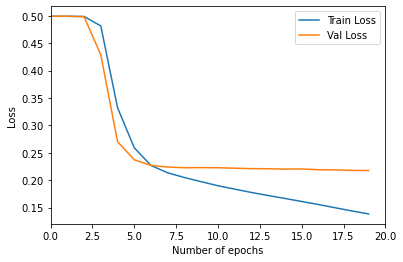

In [47]:
import  matplotlib.pyplot as plt
plt.plot(train_loss,label = "Train Loss")
plt.plot(val_loss,label = "Val Loss")
plt.xlim(0,20)
plt.legend()
#plt.legend("Train Loss","Val Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")

In [ ]:
#Reference Gao,Yang, LSTM-Lab9 ,Royal Holloway, University Of London 